In [1]:
# import matplotlib
# matplotlib.font_manager.fontManager.addfont('sarabun.ttf')
# matplotlib.rcParams['font.family'] = 'Sarabun'

In [2]:
from utils.thai_lottery_scraper import ThaiLotteryScraper

df = ThaiLotteryScraper().scrape_df(36)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        844 non-null    datetime64[ns]
 1   day                         844 non-null    object        
 2   th_month                    844 non-null    object        
 3   year                        844 non-null    object        
 4   1st_prize                   844 non-null    object        
 5   2digit_up                   844 non-null    object        
 6   3digit_up                   844 non-null    object        
 7   2digit_buttom               844 non-null    object        
 8   3digit_front,3digit_bottom  844 non-null    object        
 9   3digit_front                844 non-null    object        
 10  3digit_bottom               844 non-null    object        
dtypes: datetime64[ns](1), object(10)
memory usage: 72.7+ KB


In [3]:
from utils.data_extractor import extract_zodiac_signs

df['thai_zodiac'] = df['date'].apply(extract_zodiac_signs)
df['dow'] = df['date'].dt.day_name()

df.head(3)

,date,day,th_month,year,1st_prize,2digit_up,3digit_up,2digit_buttom,"3digit_front,3digit_bottom",3digit_front,3digit_bottom,thai_zodiac,dow
0,2025-04-16,16,เมษายน,2568,266227,27,227,85,"[254, 413, 474, 760]","[254, 413]","[474, 760]",Snake,Wednesday
1,2025-04-01,1,เมษายน,2568,669687,87,687,36,"[635, 760, 180, 666]","[635, 760]","[180, 666]",Snake,Tuesday
2,2025-03-16,16,มีนาคม,2568,757563,63,563,32,"[595, 927, 309, 457]","[595, 927]","[309, 457]",Snake,Sunday


In [4]:
df.to_csv('lottery_data_extracted.csv', index=False)

In [5]:
df_zodiac = df.groupby('thai_zodiac').agg({'1st_prize': 'count'}).reset_index()
df_zodiac

,thai_zodiac,1st_prize
0,Dog,72
1,Dragon,71
2,Goat,72
3,Horse,72
4,Monkey,72
5,Ox,72
6,Pig,72
7,Rabbit,72
8,Rat,69
9,Rooster,72


In [6]:
# find missing data

df.sort_values(by='date', ascending=False, inplace=True)
df['day2before_prize'] = df['date'].diff(-1).dt.days
df['day2before_prize'].value_counts()

day2before_prize
15.0    464
16.0    233
14.0     81
17.0     29
13.0     24
18.0      9
12.0      2
61.0      1
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

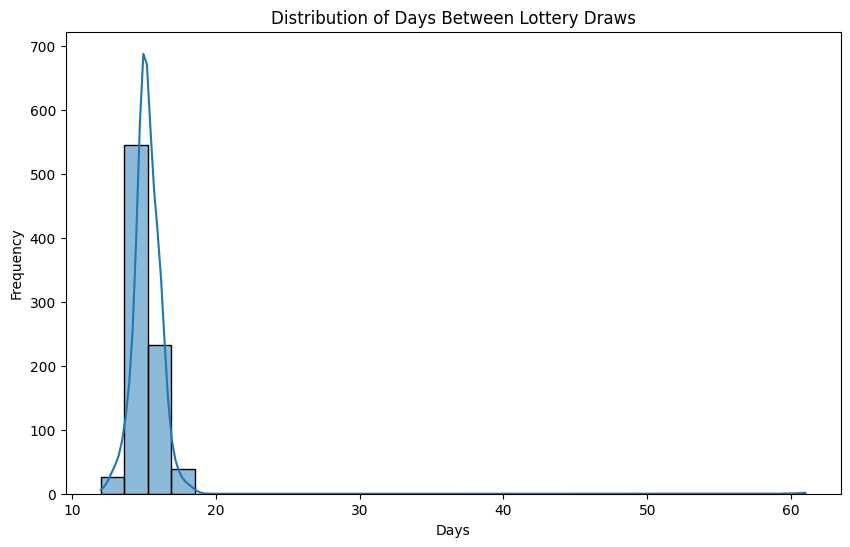

In [7]:
# plot distribution of days between prizes using sns seaborn

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['day2before_prize'].dropna(), bins=30, kde=True)
plt.title('Distribution of Days Between Lottery Draws')

plt.xlabel('Days')
plt.ylabel('Frequency')

In [8]:
df.to_csv('lottery_data_findweirddate.csv', index=False)

<Figure size 1200x600 with 0 Axes>

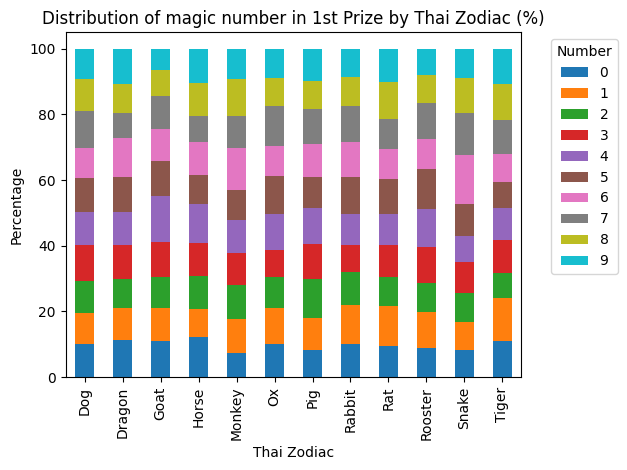

In [9]:
# Merge zodiac data with first digit frequency
df_temp = df.copy()
df_temp['1st_prize_lst'] = df_temp['1st_prize'].apply(lambda x: list(str(x)))
df_temp = df_temp.explode('1st_prize_lst')
zodiac_digit_counts = df_temp.groupby(['thai_zodiac', '1st_prize_lst']).size().reset_index(name='count')

# Calculate percentages within each zodiac sign
zodiac_totals = zodiac_digit_counts.groupby('thai_zodiac')['count'].sum()
zodiac_digit_counts['percentage'] = zodiac_digit_counts.apply(
    lambda x: (x['count'] / zodiac_totals[x['thai_zodiac']]) * 100, axis=1)

# Create pivot table with percentages for visualization
pivot_df = zodiac_digit_counts.pivot(index='thai_zodiac', columns='1st_prize_lst', values='percentage')

# Plot
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True)
plt.title('Distribution of magic number in 1st Prize by Thai Zodiac (%)')
plt.xlabel('Thai Zodiac')
plt.ylabel('Percentage')
plt.legend(title='Number', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

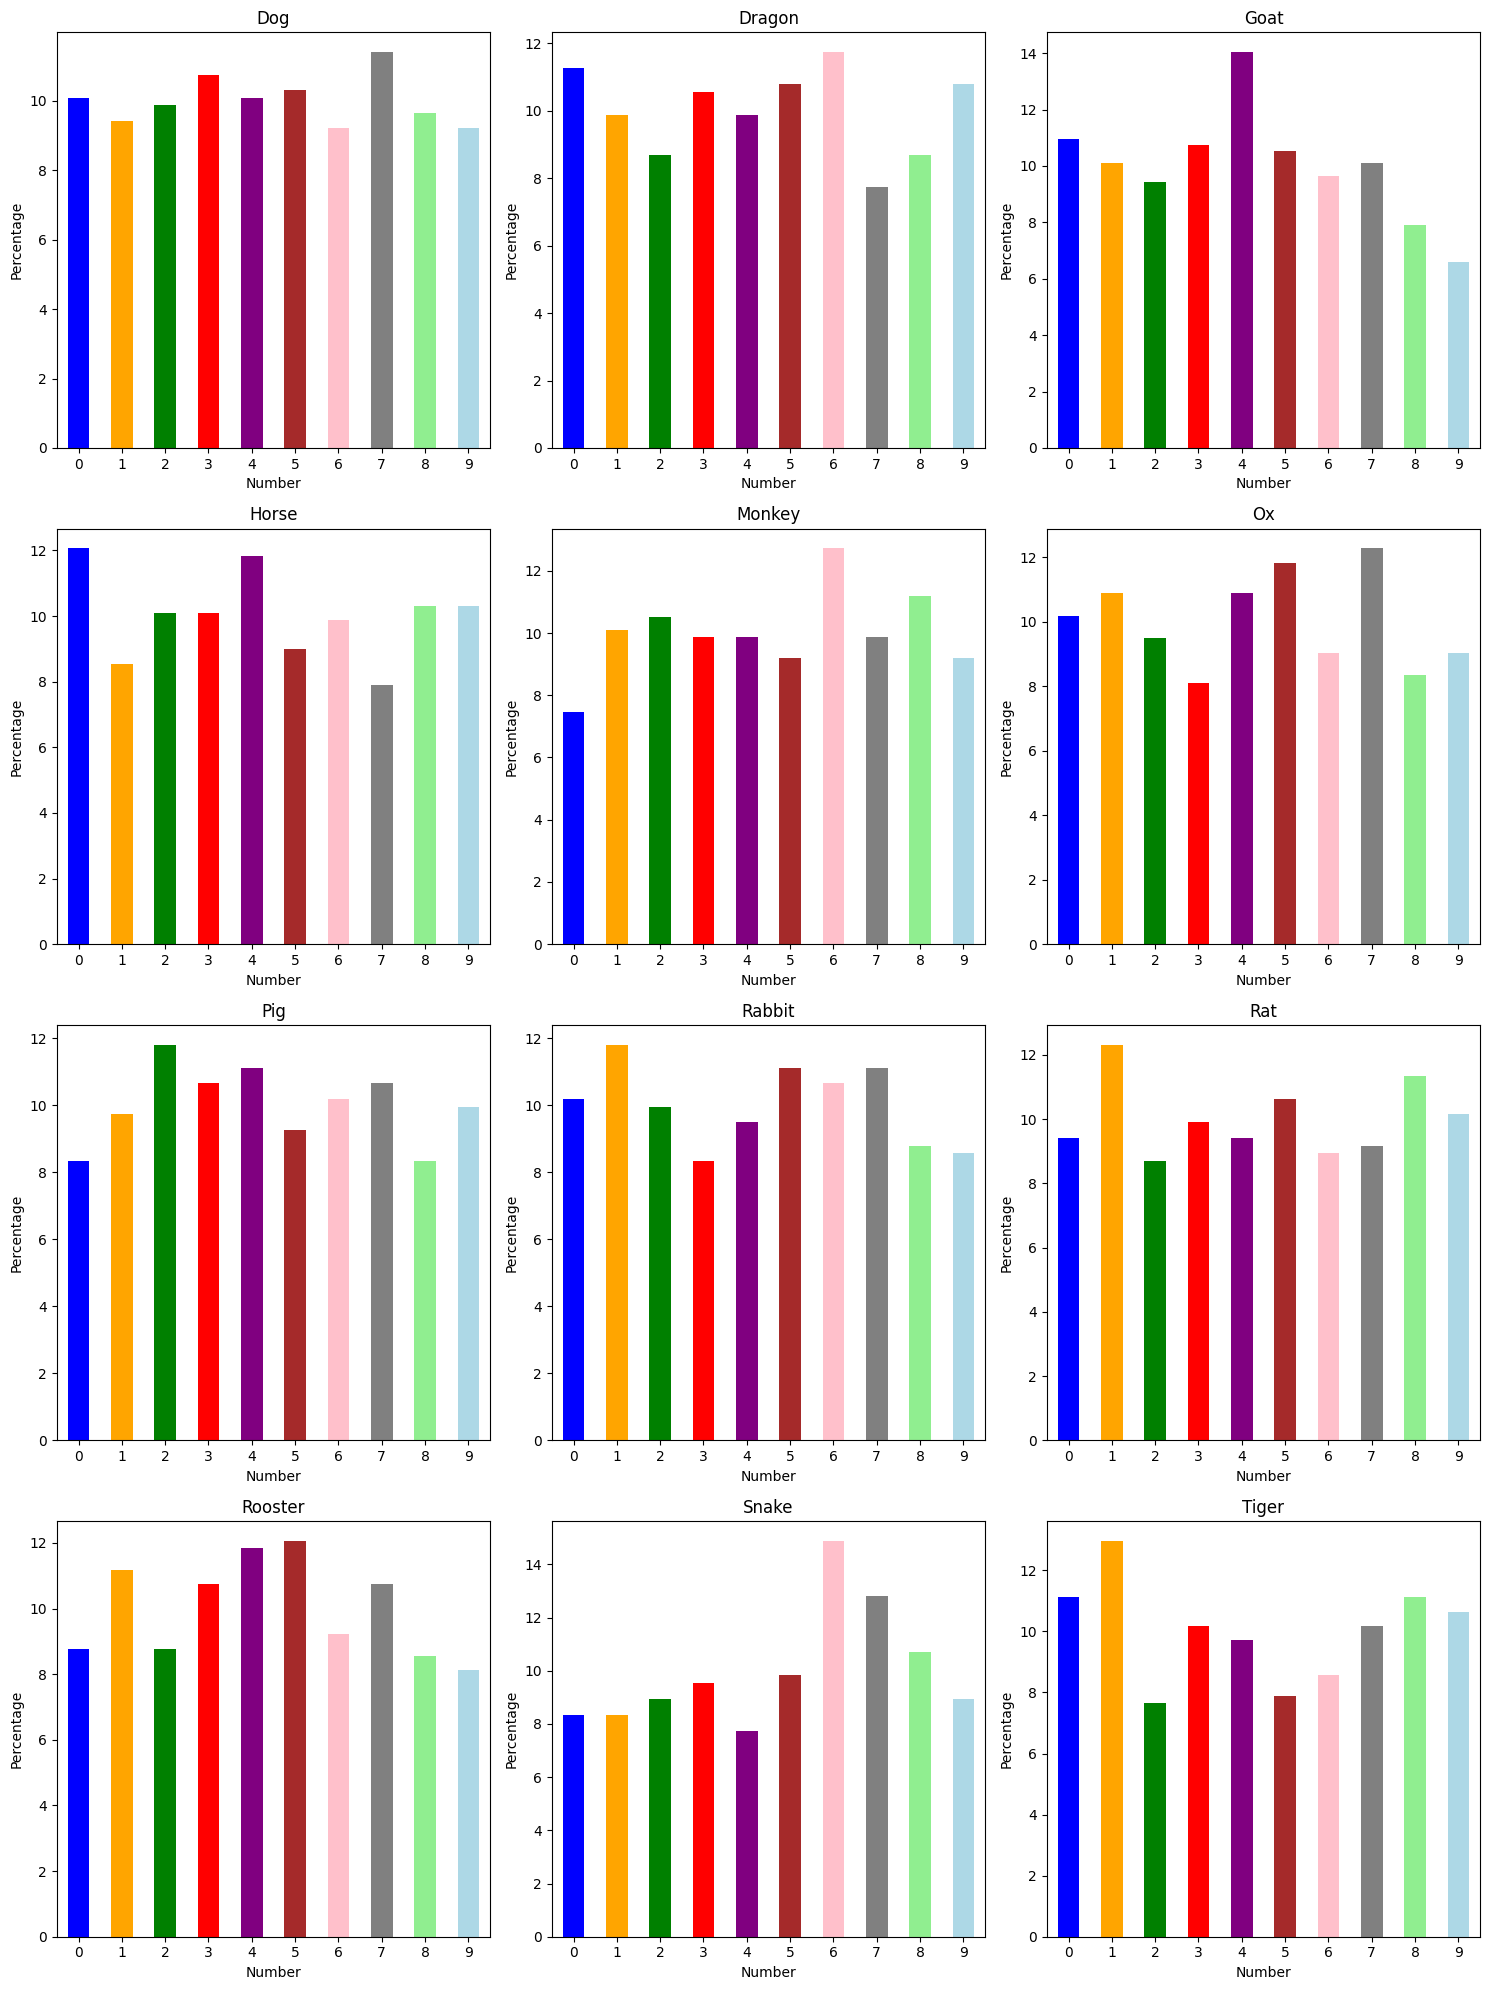

In [17]:
# Define colors for each number (0-9)
number_colors = {
    '0': 'blue',
    '1': 'orange',
    '2': 'green',
    '3': 'red',
    '4': 'purple',
    '5': 'brown',
    '6': 'pink',
    '7': 'grey',
    '8': 'lightgreen',
    '9': 'lightblue'
}

# Create a figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.ravel()

# Plot each zodiac sign in a separate subplot
for idx, zodiac in enumerate(pivot_df.index):
    data = pivot_df.loc[zodiac]
    bars = data.plot(kind='bar', ax=axes[idx], color=[number_colors[str(i)] for i in range(10)])
    axes[idx].set_title(f'{zodiac}')
    axes[idx].set_xlabel('Number')
    axes[idx].set_ylabel('Percentage')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

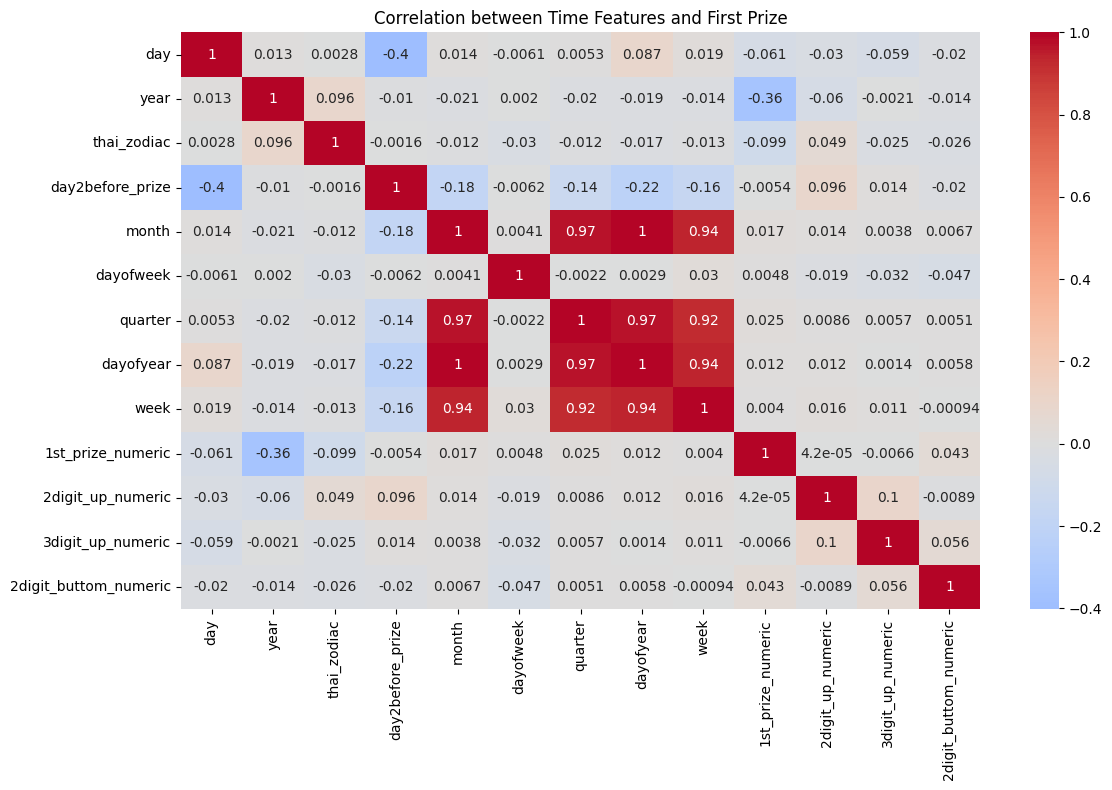

In [11]:
# Extract time features
df_time = df.copy()
df_time['year'] = df_time['date'].dt.year
df_time['month'] = df_time['date'].dt.month
df_time['day'] = df_time['date'].dt.day
df_time['dayofweek'] = df_time['date'].dt.dayofweek
df_time['quarter'] = df_time['date'].dt.quarter
df_time['dayofyear'] = df_time['date'].dt.dayofyear
df_time['week'] = df_time['date'].dt.isocalendar().week
df_time['thai_zodiac'] = df_time['thai_zodiac'].astype('category').cat.codes

# Convert first prize to numeric values for correlation
df_time['1st_prize_numeric'] = df_time['1st_prize'].astype(int)
# Convert prize digits to numeric for correlation analysis
df_time['2digit_up_numeric'] = df_time['2digit_up'].astype(int)
df_time['3digit_up_numeric'] = df_time['3digit_up'].astype(int)
df_time['2digit_buttom_numeric'] = df_time['2digit_buttom'].astype(int)

# Calculate correlations
# {'pearson', 'kendall', 'spearman'}
correlation_matrix = df_time.corr(numeric_only=True, method='spearman')

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Time Features and First Prize')
plt.tight_layout()

In [12]:
import pandas as pd

df_1prize = pd.DataFrame(df['1st_prize'].apply(lambda x: [{"digit":i+1,"value":digit} for i, digit in enumerate(x)]).explode().reset_index(drop=True).to_list())
df_1prize.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   digit   5184 non-null   int64 
 1   value   5184 non-null   object
dtypes: int64(1), object(1)
memory usage: 81.1+ KB


In [13]:
df_1prize.groupby('digit')['value'].value_counts().sort_values(ascending=False).reset_index().to_csv('1prize_digit_value_counts.csv', index=False, header=False)

In [14]:

df_1prize = pd.DataFrame(df['1st_prize'].apply(lambda x: [
                         {"value [i]": x[i], "value [i+1]": x[i+1]} for i in range(len(x)-1)]).explode().reset_index(drop=True).to_list())
df_1prize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   value [i]    4340 non-null   object
 1   value [i+1]  4340 non-null   object
dtypes: object(2)
memory usage: 67.9+ KB


In [15]:
df_1prize.groupby('value [i]')['value [i+1]'].value_counts().sort_values(ascending=False).reset_index(
).to_csv('1prize_what_next.csv', index=False, header=False)